In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



In [22]:
# --- 1. DATA FETCHING (SPY as Proxy for SPX) ---
def get_vol_surface(ticker_symbol="SPY"):
    print(f"Fetching option chain for {ticker_symbol}...")
    tk = yf.Ticker(ticker_symbol)

    # Get Spot Price
    try:
        spot = tk.history(period="1d")['Close'].iloc[-1]
    except:
        spot = 580.0  # Fallback if API fails

    # Get Expirations
    expirations = tk.options

    # Storage for valid options
    options_list = []

    # Loop through expirations (limit to ~2 years for speed)
    current_date = datetime.now()
    for e in expirations:
        opt_date = datetime.strptime(e, "%Y-%m-%d")
        T = (opt_date - current_date).days / 365.0
        if T < 0.1 or T > 2.5:
            continue  # Skip very short/long dated

        # Get Chain
        try:
            chain = tk.option_chain(e)
            calls = chain.calls

            # Filter for liquidity and OTM/ATM data (Cleaner surface)
            # We focus on strikes 70% to 130% of spot
            calls = calls[(calls['strike'] > spot * 0.7) &
                          (calls['strike'] < spot * 1.3)]
            calls = calls[calls['impliedVolatility'] > 0.01]

            for index, row in calls.iterrows():
                options_list.append({
                    'T': T,
                    'K': row['strike'],
                    'IV': row['impliedVolatility']
                })
        except Exception as err:
            print(f"Skipping exp {e}: {err}")

    df = pd.DataFrame(options_list)
    # FILTERING STEP: Clean the data before calibration

    # 2. Filter for "Moneyness" (Keep strikes within 80% - 120% of spot)
    # Discard deep OTM/ITM options which have noisy IVs
    df_clean = df[
        (df['K'] > spot * 0.9) & 
        (df['K'] < spot * 1.1)
    ].copy()

    # 3. Filter for "Sane" Volatility
    # SPY vol shouldn't be > 40% (0.4) unless we are in a crash.
    # It also shouldn't be < 5% (0.05).
    df_clean = df_clean[
        (df_clean['IV'] > 0.05) & 
        (df_clean['IV'] < 0.35)
    ]
    

    return spot, df_clean

In [13]:
get_vol_surface(ticker_symbol="SPY")

Fetching option chain for SPY...


(680.5900268554688,
              T      K        IV
 28    0.106849  584.0  0.398077
 29    0.106849  585.0  0.395087
 30    0.106849  586.0  0.392523
 31    0.106849  587.0  0.389990
 32    0.106849  588.0  0.387000
 ...        ...    ...       ...
 1880  2.484932  795.0  0.197396
 1881  2.484932  800.0  0.195519
 1882  2.484932  805.0  0.193627
 1883  2.484932  810.0  0.191796
 1884  2.484932  815.0  0.190003
 
 [1499 rows x 3 columns])

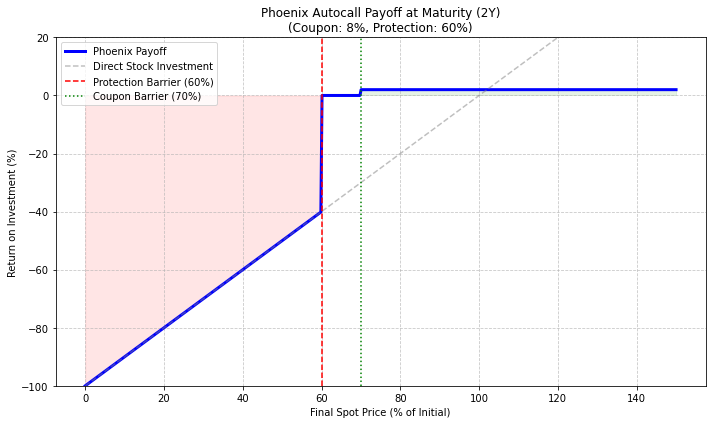

In [93]:
def plot_phoenix_payoff_diagram(spot_ref=1000):
    # --- 1. Product Parameters ---
    Notional = 1000
    Coupon_Rate = 0.08  # 8% p.a.
    Obs_Freq = 0.25     # Quarterly
    Maturity = 2.0

    # Barriers
    B_Auto = 1.00 * spot_ref  # 100%
    B_Coup = 0.70 * spot_ref  # 70%
    B_Prot = 0.60 * spot_ref  # 60% (KI Put Strike)

    # Coupon Amount per Period
    coupon_amt_cash = Notional * Coupon_Rate * Obs_Freq

    # --- 2. Generate Grid of Final Spot Prices (S_T) ---
    # From 0% to 150% of Spot
    S_T = np.linspace(0, 1.5 * spot_ref, 500)

    # --- 3. Calculate Payoff Logic (At Maturity) ---
    payoffs = []

    for s in S_T:
        # Scenario A: Above Autocall/Coupon Barrier (Best Case)
        # Note: At maturity, usually B_Coup determines if you get the final coupon.
        # Sometimes B_Prot is used. Let's assume B_Coup for the coupon.

        payoff = 0.0

        # 1. Capital Repayment Logic
        if s >= B_Prot:
            # Protected: Get Notional back
            payoff = Notional
        else:
            # Not Protected: Capital Loss (Linear)
            payoff = Notional * (s / spot_ref)

        # 2. Final Coupon Logic
        # If we are above the Coupon Barrier at maturity, we get the final coupon
        # (And potentially missed coupons, but we assume no missed memory for this simple static plot)
        if s >= B_Coup:
            payoff += coupon_amt_cash

        payoffs.append(payoff)

    # Convert to Percentage Return for easier reading
    # (Payoff - Notional) / Notional
    returns_pct = [(p - Notional) / Notional * 100 for p in payoffs]
    spot_pct = [s / spot_ref * 100 for s in S_T]

    # --- 4. Plotting ---
    plt.figure(figsize=(10, 6))

    # Plot Payoff Line
    plt.plot(spot_pct, returns_pct, linewidth=3,
             color='blue', label='Phoenix Payoff')

    # Plot "Direct Investment" Line (Holding the stock) for comparison
    plt.plot(spot_pct, [s - 100 for s in spot_pct], '--',
             color='gray', alpha=0.5, label='Direct Stock Investment')

    # Visual Guides (Barriers)
    plt.axvline(x=B_Prot/spot_ref*100, color='red', linestyle='--',
                label=f'Protection Barrier ({B_Prot/spot_ref:.0%})')
    plt.axvline(x=B_Coup/spot_ref*100, color='green', linestyle=':',
                label=f'Coupon Barrier ({B_Coup/spot_ref:.0%})')

    # Shade the Loss Area
    plt.fill_between(spot_pct, returns_pct, 0, where=(np.array(returns_pct) < 0),
                     color='red', alpha=0.1)

    # Shade the Profit Area
    plt.fill_between(spot_pct, returns_pct, 0, where=(np.array(returns_pct) > 0),
                     color='green', alpha=0.1)

    # Formatting
    plt.title(
        f"Phoenix Autocall Payoff at Maturity (2Y)\n(Coupon: {Coupon_Rate:.0%}, Protection: {B_Prot/spot_ref:.0%})")
    plt.xlabel("Final Spot Price (% of Initial)")
    plt.ylabel("Return on Investment (%)")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Limit Y-axis to see detail better
    plt.ylim(-100, 20)

    plt.tight_layout()
    plt.show()


plot_phoenix_payoff_diagram()

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.stats import norm

In [ ]:
# ==========================================
# 1. HESTON ENGINE (NORMALIZED)
# ==========================================
def heston_price_normalized(K_norm, T, r, kappa, theta, xi, rho, v0):
    """ Calculates Heston Call Price for Spot=1.0 """
    S0 = 1.0

    def char_func(u):
        d = np.sqrt((rho * xi * u * 1j - kappa)**2 + xi**2 * (u * 1j + u**2))
        g = (kappa - rho * xi * u * 1j - d) / (kappa - rho * xi * u * 1j + d)
        C = (kappa * theta / xi**2)
        A = (kappa - rho * xi * u * 1j - d)
        val1 = np.exp(r * u * 1j * T)
        val2 = S0**(u * 1j) * ((1 - g * np.exp(-d * T)) / (1 - g))**(-2 * C)
        val3 = np.exp(C * A * T)
        val4 = np.exp((v0 / xi**2) * A * (1 - np.exp(-d * T)) /
                      (1 - g * np.exp(-d * T)))
        return val1 * val2 * val3 * val4

    def integrand(u):
        cf_val = char_func(u - 0.5j)
        num = np.exp(-1j * u * np.log(K_norm)) * cf_val
        den = u**2 + 0.25
        return num.real / den

    integral, _ = quad(integrand, 0, 100)
    price = S0 - (np.sqrt(K_norm * S0) / np.pi) * np.exp(-r * T / 2) * integral
    return max(price, 0.0)


def bs_price(S, K, T, r, sigma):
    """ Standard Black-Scholes Call Price """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# ==========================================
# 2. CALIBRATION ROUTINE
# ==========================================


def calibrate_heston_global(spot, df_data):
    print(f"Starting Global Calibration (Differential Evolution)...")

    # FILTER DATA

    df = df_data.copy()
    # Filter Moneyness (80% to 120%)
    df = df[(df['K'] > spot*0.80) & (df['K'] < spot*1.20)]
    # Filter Vol Sanity
    df = df[(df['IV'] > 0.05) & (df['IV'] < 0.50)]

    # Use a subset if large
    if len(df) > 30:
       df = df.sample(30, random_state=42)
    print(f"Calibrating to {len(df)} options...")

    # NORMALIZE DATA

    r = 0.045
    normalized_targets = []

    for _, row in df.iterrows():
        # 1. Convert IV to Price (Black Scholes)
        bs_p = bs_price(spot, row['K'], row['T'], r, row['IV'])

        # 2. Normalize: Price / Spot
        norm_p = bs_p / spot

        # 3. Store normalized strike too: K / Spot
        normalized_targets.append({
            'T': row['T'],
            'K_norm': row['K'] / spot,
            'MarketPrice_norm': norm_p,
            'Weight': 1.0 / norm_p if norm_p > 0.001 else 1.0  # Weight by inverse price
        })

    # COST FUNCTION

    def cost_function(params):
        kappa, theta, xi, rho, v0 = params

        # Hard constraints for integration stability
        if 2*kappa*theta < xi**2:
            # Feller violation penalty (optional, keeps things stable)
            return 1e6

        error = 0.0
        for item in normalized_targets:
            model_p = heston_price_normalized(
                item['K_norm'], item['T'], r,
                kappa, theta, xi, rho, v0
            )

            # Weighted Squared Error
            diff = (model_p - item['MarketPrice_norm'])
            error += (diff * item['Weight']) ** 2

        return error  # Sum of errors

    # BOUNDS (Kappa, Theta, Xi, Rho, v0)
    bounds = [
        (0.5, 10.0),  # Kappa
        (0.01, 0.20),  # Theta (Long vol 10%-45%)
        (0.01, 2.0),  # Xi
        (-0.9, -0.3),  # Rho (Force negative skew)
        (0.01, 0.20)  # v0 (Current vol 10%-45%)
    ]

    # RUN GLOBAL OPTIMIZER
    # This does NOT use an initial guess. It evolves a population.
    result = differential_evolution(
        cost_function,
        bounds,
        strategy='best1bin',
        # Limit generations for speed (increase to 50 for better results)
        maxiter=20,
        popsize=10,     # Population size
        disp=True       # Print progress
    )

    return result



# ==========================================
# 3. EXECUTION
# ==========================================
if __name__ == "__main__":
    # Assuming you have 'spot' and 'df_iv' from previous steps
    # If not, recreate dummy data or re-fetch:
    # spot, df_iv = get_clean_market_data("SPY")
    spot = 680.5900268554688
    #df_iv = pd.read_csv('option')
    # Run
    '''
    res = calibrate_heston_global(spot, df_iv)

    print("\n" + "="*30)
    print("FINAL CALIBRATION RESULT")
    print("="*30)
    p = res.x
    print(f"Kappa (Speed):    {p[0]:.4f}")
    print(f"Theta (Long Var): {p[1]:.4f} (Vol ~ {np.sqrt(p[1]):.2%})")
    print(f"Xi (Vol of Vol):  {p[2]:.4f}")
    print(f"Rho (Corr):       {p[3]:.4f}")
    print(f"v0 (Current Var): {p[4]:.4f} (Vol ~ {np.sqrt(p[4]):.2%})")
    '''
    

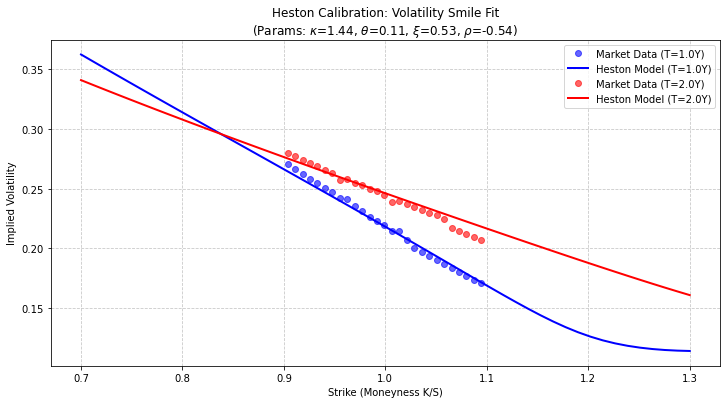

In [ ]:
def heston_price_lewis(S, K, T, r, kappa, theta, xi, rho, v0):
    """
    Heston Call Price using Lewis (2001) formula
    """
    rho = -rho
    # 1. Fourier Transform Variables
    # k = log-moneyness
    k = np.log(S / K) + r * T

    def integrand(u):
        # Lewis works with z = u - i/2
        z = u - 0.5j

        # Characteristic Function Logic
        d = np.sqrt((rho * xi * z * 1j - kappa)**2 + xi**2 * (z * 1j + z**2))
        g = (kappa - rho * xi * z * 1j - d) / (kappa - rho * xi * z * 1j + d)

        # Complex exponents
        term_exp = np.exp(-d * T)

        # C and D terms
        C = (kappa * theta / xi**2) * ((kappa - rho * xi * z * 1j - d) * T -
                                       2 * np.log((1 - g * term_exp) / (1 - g)))
        D = (kappa - rho * xi * z * 1j - d) / xi**2 * \
            ((1 - term_exp) / (1 - g * term_exp))

        # Characteristic Function
        phi = np.exp(C + D * v0)

        # Lewis Integrand: Re[ exp(-i*u*k) * Phi / (u^2 + 1/4) ]
        num = np.exp(-1j * u * k) * phi
        den = u**2 + 0.25
        return (num / den).real

    # 2. Integrate
    # Limit=1000 fixes the jagged lines.
    # Range 0 to 200 is sufficient for Lewis (decays fast).
    integral, err = quad(integrand, 0, 200, limit=1000)

    # 3. Final Formula
    # Call = S - sqrt(S*K)*exp(-rT/2)/pi * Integral
    price = S - (np.sqrt(S * K) * np.exp(-r * T / 2) / np.pi) * integral

    return max(price, 1e-10)  # Safety floor

# ==========================================
# 2. BLACK-SCHOLES IMPLIED VOL SOLVER
# ==========================================


def solve_iv(price, S, K, T, r):
    # Safety Check: Intrinsic Value
    intrinsic = max(S - K*np.exp(-r*T), 0)
    if price <= intrinsic + 1e-7:
        return np.nan

    def objective(sigma):
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        bs_p = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
        return bs_p - price

    try:
        return brentq(objective, 0.01, 3.0)  # Search 1% to 300%
    except:
        return np.nan

# ==========================================
# 3. PLOTTING FUNCTION
# ==========================================


def plot_calibration_smile(market_data, params, selected_maturities=[1.0, 2.0]):
    """
    Plots Market IV vs Heston Model IV.
    
    market_data: List of dicts or DataFrame with keys ['strike', 'maturity', 'market_iv']
    params: Dictionary of calibrated Heston parameters
    """

    # Unpack Parameters
    kappa = params['kappa']
    theta = params['theta']
    xi = params['xi']
    rho = params['rho']
    v0 = params['v0']
    r = 0.045  # Risk-free rate (matches your report)
    S_ref = 1.0    # Normalized Spot

    plt.figure(figsize=(12, 6))

    # Loop through the requested maturities (e.g., 1 Year and 2 Years)
    for i, T_target in enumerate(selected_maturities):

        # --- A. Filter Market Data for this Maturity ---
        # (Assuming simple tolerance of +/- 0.1 years for grouping)
        subset = [d for d in market_data if abs(
            d['T'] - T_target) < 0.05]

        if not subset:
            print(f"No market data found near T={T_target}")
            continue

        market_strikes = [d['K'] for d in subset]
        market_ivs = [d['IV'] for d in subset]

        # --- B. Generate Smooth Heston Curve ---
        # Create a range of strikes (normalized)
        # e.g., from 70% to 130% of Spot
        smooth_strikes = np.linspace(0.7, 1.3, 50)
        heston_ivs = []

        for K in smooth_strikes:
            # 1. Get Heston Price (using your function)
            h_price = heston_price_lewis(S_ref, K, T_target, r, **params)
            # 2. Convert to Implied Volatility
            iv = solve_iv(h_price, S_ref, K, T_target, r)
            heston_ivs.append(iv)

        # --- C. Plotting ---
        color = 'blue' if i == 0 else 'red'

        # Plot Discrete Market Data
        plt.plot(market_strikes, market_ivs, 'o', color=color,
                 label=f'Market Data (T={T_target}Y)', alpha=0.6)

        # Plot Smooth Heston Curve
        plt.plot(smooth_strikes, heston_ivs, '-', color=color, linewidth=2,
                 label=f'Heston Model (T={T_target}Y)')

    plt.title(
        f"Heston Calibration: Volatility Smile Fit\n(Params: $\kappa$=1.44, $\\theta$=0.11, $\\xi$=0.53, $\\rho$=-0.54)")
    plt.xlabel("Strike (Moneyness K/S)")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


# ==========================================
# 4. EXAMPLE USAGE
# ==========================================
if __name__ == "__main__":
    # 1. Your Calibrated Parameters
    calibrated_params = {
        'kappa': 1.44,
        'theta': 0.11,
        'xi': 0.53,
        'rho': -0.54,
        'v0': 0.0226
    }
    #4, .065, 2, -.89. .04
    df_iv = pd.read_csv('option')
    df_iv['K'] = df_iv['K'] / 680.59
    df_iv_list = df_iv.to_dict('records')
    # 3. Run the Plotter
    plot_calibration_smile(df_iv_list, calibrated_params)

Heston Monte Carlo

In [14]:
from scipy.integrate import quad

In [101]:
def price_phoenix_final(current_spot, fixed_barriers, params, 
                        initial_spot=1000.0, coupon = 0.08, r = 0.045,
                        seed=2025, num_paths=50000, use_antithetic=True):
    # barriers
    B_Auto = fixed_barriers['Auto']
    B_Coup = fixed_barriers['Coup']
    B_Prot = fixed_barriers['Prot']

    # --- 1. PARAMETERS (Your Validated Set) ---
    kappa = params["kappa"]
    theta = params["theta"]
    xi = params["xi"]
    rho = params["rho"]
    v0 = params["v0"]

    # --- 2. GRID & PRODUCT ---
    Maturity = 2.0
    dt = 0.001
    steps = int(Maturity / dt)
    Obs_Freq = 0.25
    Notional = 1000
    Coupon_Rate = coupon

    obs_indices = [int(i / dt)
                   for i in np.arange(Obs_Freq, Maturity + 0.001, Obs_Freq)]

    # --- 3. NOISE GENERATION (THE SWITCH) ---
    if use_antithetic:
        # Generate half, then mirror
        half = int(num_paths / 2)
        np.random.seed(seed)
        Z_S_half = np.random.standard_normal((steps, half))
        Z_V_half = np.random.standard_normal((steps, half))

        Z_S = np.concatenate((Z_S_half, -Z_S_half), axis=1)
        Z_V = np.concatenate((Z_V_half, -Z_V_half), axis=1)
    else:
        # Brute force: Generate full independent set
        Z_S = np.random.standard_normal((steps, num_paths))
        Z_V = np.random.standard_normal((steps, num_paths))

    # --- 4. ANDERSEN QE CONSTANTS ---
    exp_kdt = np.exp(-kappa * dt)
    k0 = - (rho * kappa * theta) / xi * dt
    k1 = (rho * kappa / xi) - 0.5
    k2 = rho / xi
    Psi_cutoff = 1.5
    sqrt_1_rho2 = np.sqrt(1 - rho**2)

    # --- 5. TIME LOOP (Identical logic) ---
    S = np.full(num_paths, current_spot)
    v = np.full(num_paths, v0)
    discounted_payoffs = np.zeros(num_paths)
    active_paths = np.ones(num_paths, dtype=bool)
    unpaid_coupons = np.zeros(num_paths)

    # Optimization: Pre-calc Uniforms for QE
    U_vol_grid = norm.cdf(Z_V)

    for t in range(steps):
        v_curr = v
        m = theta + (v_curr - theta) * exp_kdt
        s2 = (v_curr * xi**2 * exp_kdt / kappa) * (1 - exp_kdt) + \
            (theta * xi**2 / (2 * kappa)) * (1 - exp_kdt)**2
        Psi = s2 / (m**2)

        v_next = np.zeros(num_paths)
        high_vol = (Psi <= Psi_cutoff)
        low_vol = ~high_vol

        if np.any(high_vol):
            idx = high_vol
            invPsi = 1.0 / Psi[idx]
            b2 = 2 * invPsi - 1 + np.sqrt(2 * invPsi) * np.sqrt(2 * invPsi - 1)
            a = m[idx] / (1 + b2)
            b = np.sqrt(b2)
            v_next[idx] = a * (b + Z_V[t][idx])**2

        if np.any(low_vol):
            idx = low_vol
            p = (Psi[idx] - 1) / (Psi[idx] + 1)
            beta = (1 - p) / m[idx]
            u_vec = U_vol_grid[t][idx]
            v_sub = np.zeros(len(u_vec))
            mask_nz = (u_vec > p)
            term = (1 - p[mask_nz]) / (1 - u_vec[mask_nz])
            v_sub[mask_nz] = (1.0 / beta[mask_nz]) * np.log(term)
            v_next[idx] = v_sub

        int_v = 0.5 * (v_curr + v_next) * dt
        log_drift = (r * dt) + k0 + k1 * int_v + k2 * (v_next - v_curr)
        log_diff = sqrt_1_rho2 * np.sqrt(int_v) * Z_S[t]
        S = S * np.exp(log_drift + log_diff)
        v = v_next

        if (t + 1) in obs_indices:
            # Current time in years
            t_year = (t + 1) * dt

            # Calculate Discount Factor for THIS moment
            df = np.exp(-r * t_year)

            # 1. Check Barriers
            is_auto = (S >= B_Auto)
            is_coup = (S >= B_Coup)

            coupon_cash = Notional * Coupon_Rate * Obs_Freq

            # 2. Handle Autocall (Active & Hit Auto Barrier)
            ac_hit = active_paths & is_auto
            if np.any(ac_hit):
                # Pay: Notional + Current Coupon + Memory
                total_payment = Notional + coupon_cash + unpaid_coupons[ac_hit]

                # DISCOUNT IMMEDIATELY and add to total
                discounted_payoffs[ac_hit] += total_payment * df

                # Kill path
                active_paths[ac_hit] = False

            # 3. Handle Coupon Only (Active & No Autocall & Hit Coupon Barrier)
            # Note: We only check 'active_paths' which were just updated above
            coup_hit = active_paths & is_coup
            if np.any(coup_hit):
                # Pay: Current Coupon + Memory
                total_payment = coupon_cash + unpaid_coupons[coup_hit]

                # DISCOUNT IMMEDIATELY
                discounted_payoffs[coup_hit] += total_payment * df

                # Reset memory
                unpaid_coupons[coup_hit] = 0.0

            # 4. Handle Miss (Active & Missed Coupon)
            miss_hit = active_paths & (~is_coup)
            if np.any(miss_hit):
                # Accumulate memory (undiscounted, as it pays later)
                unpaid_coupons[miss_hit] += coupon_cash

    if np.any(active_paths):
        # Discount Factor for Maturity
        df_T = np.exp(-r * Maturity)

        final_S = S[active_paths]

        # A. Redemption Amount (Capital Protection Check)
        # Default: Loss
        redemption = Notional * (final_S / initial_spot)

        # If Safe: Full Notional
        is_safe = (final_S >= B_Prot)
        redemption[is_safe] = Notional

        # B. Final Coupon Check (Usually B_Coup applies at maturity too)
        # Note: We check B_Coup specifically for the coupon
        is_coup_T = (final_S >= B_Coup)

        final_coupon_pay = np.zeros(len(final_S))

        # Add Coupon + Memory if barrier hit
        # We need to match the indices correctly
        # Using boolean indexing on the subset 'active_paths' is tricky
        # Easier to operate on full array with mask 'active_paths'

        # Let's apply directly to 'discounted_payoffs' using the full mask logic
        # Redemption
        discounted_payoffs[active_paths] += redemption * df_T

        # Final Coupon
        # Paths that are active AND hit the coupon barrier at T
        gets_coupon = active_paths & (S >= B_Coup)
        if np.any(gets_coupon):
            payment = (Notional * Coupon_Rate * Obs_Freq) + \
                unpaid_coupons[gets_coupon]
            discounted_payoffs[gets_coupon] += payment * df_T

    # FINAL RETURN
    # No extra discounting needed here, as we discounted each flow as it happened
    return np.mean(discounted_payoffs)

Coupon rate: 0.030 |  Price: 962.429
Coupon rate: 0.035 |  Price: 965.175
Coupon rate: 0.040 |  Price: 967.922
Coupon rate: 0.045 |  Price: 970.668
Coupon rate: 0.050 |  Price: 973.415
Coupon rate: 0.055 |  Price: 976.161
Coupon rate: 0.060 |  Price: 978.907
Coupon rate: 0.065 |  Price: 981.654
Coupon rate: 0.070 |  Price: 984.400
Coupon rate: 0.075 |  Price: 987.147
Coupon rate: 0.080 |  Price: 989.893
Coupon rate: 0.085 |  Price: 992.640
Coupon rate: 0.090 |  Price: 995.386
Coupon rate: 0.095 |  Price: 998.133
Coupon rate: 0.100 |  Price: 1000.879
Coupon rate: 0.105 |  Price: 1003.626
Coupon rate: 0.110 |  Price: 1006.372
Coupon rate: 0.115 |  Price: 1009.118
Coupon rate: 0.120 |  Price: 1011.865


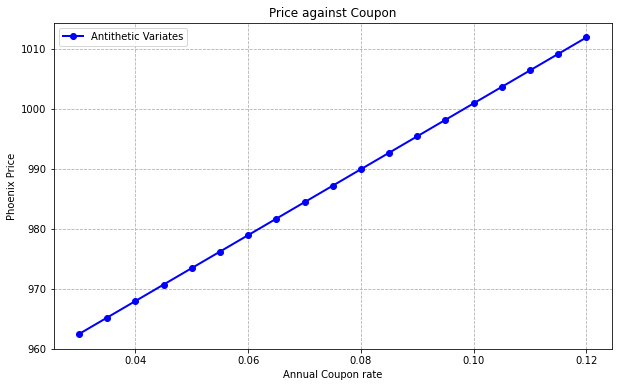

In [104]:
sp = 1000
params = {"kappa": 1.4384, "theta": 0.1109,
          "xi": 0.527, "rho": -0.542, "v0": 0.0226}
barriers = {'Auto': 1.00 * sp,
            'Coup': 0.70 * sp,
            'Prot': 0.60 * sp}
coupon = np.linspace(0.03, 0.12, 19)
prices = []
for n in coupon:
    p_anti = price_phoenix_final(
        sp, barriers, params, coupon=n, seed=25, num_paths=5000, use_antithetic=True)
    prices.append(p_anti)
    print(f"Coupon rate: {n:.3f} |  Price: {p_anti:.3f}")
plt.figure(figsize=(10, 6))

# Plot Antithetic
plt.plot(coupon, prices, 'b-o',
             linewidth=2, label='Antithetic Variates')

plt.title(f"Price against Coupon")
plt.xlabel("Annual Coupon rate")
plt.ylabel("Phoenix Price")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [105]:
def visualize_antithetic_benefit(spot_price, barriers, params):
    print("Running Variance Reduction Test...")

    # Define path counts (Logarithmic scale)
    path_counts = [1000, 2000, 5000, 10000, 25000, 50000]

    std_prices = []
    anti_prices = []

    # Run loop
    for n in path_counts:
        # 1. Standard MC
        p_std = price_phoenix_final(
            spot_price, barriers, params, seed=25, num_paths=n, use_antithetic=False)
        std_prices.append(p_std)

        # 2. Antithetic MC
        # Use same seed to ensure we start from similar "randomness base"
        p_anti = price_phoenix_final(
            spot_price, barriers, params, seed=25, num_paths=n, use_antithetic=True)
        anti_prices.append(p_anti)

        print(f"Paths: {n} | Std: {p_std:.2f} | Anti: {p_anti:.2f}")

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot Standard
    plt.plot(path_counts, std_prices, 'r--o', label='Standard MC', alpha=0.6)

    # Plot Antithetic
    plt.plot(path_counts, anti_prices, 'b-o',
             linewidth=2, label='Antithetic Variates')

    # Reference Line (Best guess of "True" price from the last run)
    true_price = anti_prices[-1]
    plt.axhline(true_price, color='gray', alpha=0.5,
                linestyle=':', label='Converged Price')

    plt.xscale('log')  # Log scale helps visualize the early convergence
    plt.title(f"Variance Reduction: Antithetic vs Standard MC")
    plt.xlabel("Number of Paths (Log Scale)")
    plt.ylabel("Phoenix Price")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()



Running Variance Reduction Test...
Paths: 1000 | Std: 1000.86 | Anti: 992.35
Paths: 2000 | Std: 997.94 | Anti: 993.50
Paths: 5000 | Std: 992.39 | Anti: 989.89
Paths: 10000 | Std: 992.43 | Anti: 992.04
Paths: 25000 | Std: 992.63 | Anti: 993.49
Paths: 50000 | Std: 992.92 | Anti: 992.32


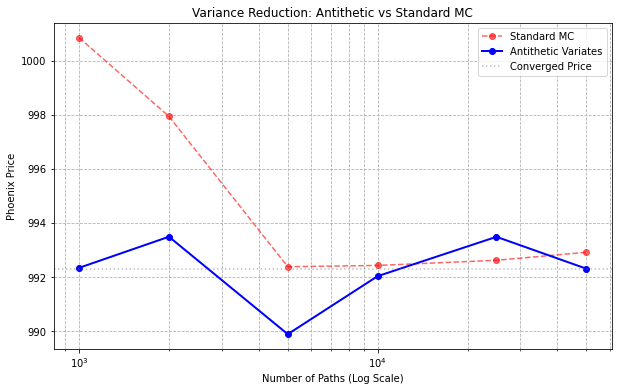

In [106]:
sp = 1000
params = {"kappa": 1.4384, "theta" : 0.1109, "xi" : 0.527, "rho" : -0.542, "v0" : 0.0226}
barriers = {'Auto': 1.00 * sp,
            'Coup': 0.70 * sp,
            'Prot': 0.60 * sp}
visualize_antithetic_benefit(sp, barriers, params)

Greeks

In [107]:
def calculate_heston_greeks(spot, params, seed=2025):
    print("Calculating First & Second Order Greeks...")
    barriers = {
        'Auto': 1.00 * spot,
        'Coup': 0.70 * spot,
        'Prot': 0.60 * spot
    }
    # 1. Bump Sizes
    dS = spot * 0.01      # 1% Spot move
    dVol = 0.01           # 1% Vol move (e.g. 20% -> 21%)

    # Helper to convert "Vol" back to Heston Variance parameters
    # We bump both v0 and theta (Parallel Shift)
    def get_bumped_params(p, vol_bump):
        # Current Vol -> Bump -> Square back to Variance
        curr_vol = np.sqrt(p['v0'])
        long_vol = np.sqrt(p['theta'])

        new_v0 = (max(curr_vol + vol_bump, 0.001))**2
        new_theta = (max(long_vol + vol_bump, 0.001))**2

        p_new = p.copy()
        p_new['v0'] = new_v0
        p_new['theta'] = new_theta
        return p_new

    # We need a pricer that accepts spot & params
    # (Assuming 'price_phoenix_heston' is defined from previous steps)
    # CRITICAL: Pass the SAME seed to every call to reduce variance
    def pricer(s, b, p):
        # Returning just price
        return price_phoenix_final(s, b, p, seed=seed, use_antithetic=True)

    # ==========================================
    # 2. RUN THE GRID (Central Differences)
    # ==========================================

    # A. Base
    # (Technically not needed for Delta/Vega if using central diff, but good for check)
    price_base = pricer(spot, barriers, params)

    # B. Spot Bumps (For Delta, Gamma)
    price_S_up = pricer(spot + dS, barriers, params)
    price_S_down = pricer(spot - dS, barriers, params)

    # C. Vol Bumps (For Vega, Vomma)
    params_V_up = get_bumped_params(params, +dVol)
    params_V_down = get_bumped_params(params, -dVol)

    price_V_up = pricer(spot, barriers, params_V_up)
    price_V_down = pricer(spot, barriers, params_V_down)

    # D. Cross Bumps (For Vanna)
    # We need Delta at Vol_Up and Delta at Vol_Down

    # Scenario: High Vol, Spot moves Up/Down
    price_S_up_V_up = pricer(spot + dS, barriers, params_V_up)
    price_S_down_V_up = pricer(spot - dS, barriers, params_V_up)

    # Scenario: Low Vol, Spot moves Up/Down
    price_S_up_V_down = pricer(spot + dS, barriers, params_V_down)
    price_S_down_V_down = pricer(spot - dS, barriers, params_V_down)

    # ==========================================
    # 3. CALCULATE GREEKS
    # ==========================================

    # --- First Order ---
    delta = (price_S_up - price_S_down) / (2 * dS)

    # Vega: Sensitivity to 1% move in Vol
    # Normalized to 1% ("per point")
    vega = (price_V_up - price_V_down) / (2 * 1.0)
    # Note: If you want raw dollar change per 1% vol, divide by 100 or keep as is depending on convention.
    # Usually Vega is quoted as "Change in Price for 1% Vol increase" -> So we just take difference.
    vega = (price_V_up - price_V_down) / 2.0

    # --- Second Order (Curvature) ---
    gamma = (price_S_up - 2*price_base + price_S_down) / (dS**2)

    # Vomma: (Vega_Up - Vega_Down) / (2 * dVol)
    # Recalculate Vegas at the bumped levels?
    # Actually, simpler: Vomma is Gamma for Volatility.
    # Vomma approx (Price_V_up - 2*Base + Price_V_down) / (dVol^2)
    # Caution: dVol is 0.01. So we divide by 0.0001. Noise amplifies!
    vomma = (price_V_up - 2*price_base + price_V_down) / (dVol**2)
    # Scale Vomma: Usually quoted per 1% vol change.
    vomma = vomma * (0.01**2)  # Scale back to "per point" intuition if needed

    # --- Cross Greeks (Vanna) ---
    # Vanna = (Delta_V_up - Delta_V_down) / (2 * dVol)

    delta_V_up = (price_S_up_V_up - price_S_down_V_up) / (2 * dS)
    delta_V_down = (price_S_up_V_down - price_S_down_V_down) / (2 * dS)

    vanna = (delta_V_up - delta_V_down) / (2 * dVol)

    return {
        "Price": price_base,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Vanna": vanna,
        "Vomma": vomma
    }

In [108]:
params = {"kappa": 1.4384, "theta": 0.1109,
          "xi": 0.527, "rho": -0.542, "v0": 0.0226}
calculate_heston_greeks(1000, params, 2025)

Calculating First & Second Order Greeks...


{'Price': 993.2681864805588,
 'Delta': 0.1305824053769129,
 'Gamma': -3.477468540040718e-05,
 'Vega': -2.275516288748463,
 'Vanna': 1.315741126524017,
 'Vomma': -0.020099181308069092}

Generating Greeks Profile...


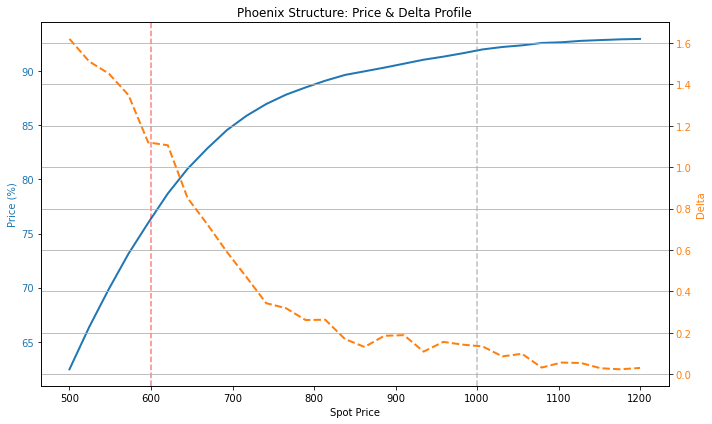

In [32]:
import matplotlib.pyplot as plt


def plot_greeks_profile(current_spot, params):
    print("Generating Greeks Profile...")

    # Range of spots: 50% to 120%
    spots = np.linspace(current_spot * 0.5, current_spot * 1.2, 30)
    deltas = []
    vegas = []
    prices = []

    # Fixed Barriers (Calculated at ref spot 1000)
    ref_spot = 1000.0
    barriers = {'Auto': 1.0*ref_spot,
                'Coup': 0.7*ref_spot, 'Prot': 0.6*ref_spot}

    for s in spots:
        
        # Calculate Greeks at this spot level
        # (Using a simplified bump just for visualization speed)
        # Note: In production, use your full `calculate_heston_greeks` function

        # 1. Base
        p = price_phoenix_final(s, barriers, params, num_paths=10000)
        prices.append(p)

        # 2. Delta Bump
        p_up = price_phoenix_final(
            s + s*0.01, barriers, params, num_paths=10000)
        d = (p_up - p) / (s*0.01)
        deltas.append(d)

        # 3. Vega Bump (Vol + 1%)
        # Hack: modify v0 and theta in params temporarily?
        # Better: Assume `params` is a dict we can copy/edit
        # For this snippet, we skip Vega loop logic to keep it short,
        # but you should include it using your existing Greek logic.
        pass

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Spot Price')
    ax1.set_ylabel('Price (%)', color=color)
    ax1.plot(spots, [p/10 for p in prices],
             color=color, linewidth=2, label='Price')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axvline(1000, color='grey', linestyle='--',
                alpha=0.5, label='Current Spot')
    ax1.axvline(600, color='red', linestyle='--', alpha=0.5, label='Barrier')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    # we already handled the x-label with ax1
    ax2.set_ylabel('Delta', color=color)
    ax2.plot(spots, deltas, color=color,
             linestyle='--', linewidth=2, label='Delta')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Phoenix Structure: Price & Delta Profile")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid(True)
    plt.show()


# Run this with your parameters
params = {"kappa": 1.4384, "theta": 0.1109, "xi" : 0.527, "rho" : -0.542, "v0" : 0.0226}
plot_greeks_profile(1000, params)